In [36]:

import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import sklearn.pipeline
%matplotlib inline


Read in the Data 

In [37]:
data = pd.read_csv("breast-cancer.csv")
data = data.drop("id", axis = 1)
data = data.replace({"M","B"},{1,0})
data = data.sample(frac=1)
Y = data["diagnosis"]
X = data.drop("diagnosis",axis = 1)
X.head()




,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
128,15.10,16.39,99.58,674.5,0.11500,0.18070,0.11380,0.08534,0.2001,0.06467,...,16.11,18.33,105.90,762.6,0.13860,0.28830,0.1960,0.14230,0.2590,0.07779
287,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,13.62,15.54,87.40,577.0,0.09616,0.11470,0.1186,0.05366,0.2309,0.06915
448,14.53,19.34,94.25,659.7,0.08388,0.07800,0.08817,0.02925,0.1473,0.05746,...,16.30,28.39,108.10,830.5,0.10890,0.26490,0.3779,0.09594,0.2471,0.07463
102,12.18,20.52,77.22,458.7,0.08013,0.04038,0.02383,0.01770,0.1739,0.05677,...,13.34,32.84,84.58,547.8,0.11230,0.08862,0.1145,0.07431,0.2694,0.06878
236,23.21,26.97,153.50,1670.0,0.09509,0.16820,0.19500,0.12370,0.1909,0.06309,...,31.01,34.51,206.00,2944.0,0.14810,0.41260,0.5820,0.25930,0.3103,0.08677


In [38]:
# check for null values 
data.isnull().sum().sum()

0

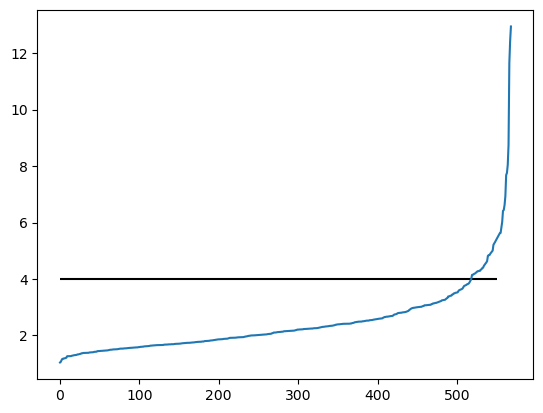

In [39]:
### Add preprocessing here (or inside the pipes)
## looking for outliers wit DBSCAN 
## finding besteps 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver="full")
processed_data = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X))) # scales and reduces dimension of data to improve distance based models
nn = NearestNeighbors(n_neighbors=4)
nn.fit(processed_data)
distance_matrix = nn.kneighbors(processed_data)[0]
distances = np.sort(distance_matrix[:,3])
plt.plot(distances)
plt.hlines(y=4, xmin=0, xmax=550)
# best eps around 3.75
plt.show()

Estimated no. of clusters: 2
Estimated no. of noise points: 31


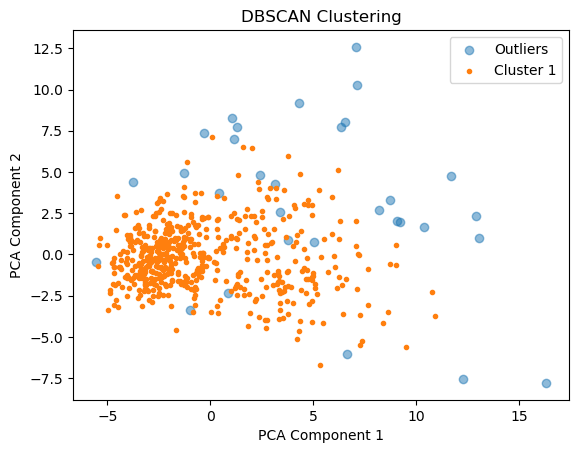

In [40]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=4, min_samples=4).fit(processed_data)
labels = db.labels_
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

for label in np.unique(labels):
    if label == -1:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='o', label='Outliers', alpha=0.5)
    else:
        plt.scatter(processed_data.loc[labels == label, 0], processed_data.loc[labels == label, 1], 
                    marker='.', label=f'Cluster {label + 1}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


/u/ajimenea/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


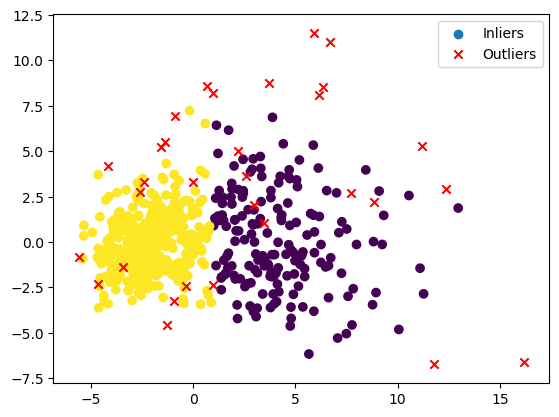

In [41]:
from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
# import matplotlib.pyplot as plt
# import numpy as np

# Detect outliers using Local Outlier Factor
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
outlier_labels = lof.fit_predict(X_scaled)


inliers = X_scaled[outlier_labels == 1]
outliers = X_scaled[outlier_labels == -1]

# Perform KMeans clustering on the original scaled data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(inliers)
labels = kmeans.labels_

pca = PCA(n_components=2).fit(inliers)
inliers_PCA = pca.transform(inliers)
outliers_PCA = pca.transform(outliers)



plt.scatter(inliers_PCA[:, 0], inliers_PCA[:, 1], c=labels, cmap='viridis', label='Inliers')
plt.scatter(outliers_PCA[:, 0], outliers_PCA[:, 1], c='red', marker='x', label='Outliers')
plt.legend()
plt.show()

In [42]:
# Print metrics
from sklearn import metrics

# Using the code for calculating and printing 
# the confusion matrix from Assignment 3
def get_confusion(test_data, results):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for i in range(len(test_data)):
        expected = test_data[i]
        if(expected):
            if (results[i]):
                TP += 1
            else:
                FN += 1
        else:
            if (results[i]): #is neg guessed pos
                FP += 1
            else: 
                TN += 1



    return TN, TP, FN, FP 

def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

# takes in a list of predicted values and test sets for each fold of crossvalidation
def PrintMetrics_list(y_actual, y_pred):
    accuracies = []
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    loops = len(y_pred)
    for i in range(loops):
        accuracies.append(sk.metrics.accuracy_score(y_actual[i],y_pred[i]))
        confusion = get_confusion(list(y_actual[i]),list(y_pred[i]))
        tn += confusion[0]
        tp += confusion[1]
        fn += confusion[2]
        fp += confusion[3]
    accuracy = np.average(accuracies)
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)

def PrintMetrics(y_actual, y_pred):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    accuracy = sk.metrics.accuracy_score(y_actual,y_pred)
    confusion = get_confusion(y_actual,y_pred)
    tn += confusion[0]
    tp += confusion[1]
    fn += confusion[2]
    fp += confusion[3]
    
    print("Accuracy:",accuracy)
    print_confusion_matrix(tp,fn,fp,tn)
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    print("Precision: ",precision)
    print("Recall:",recall)
    



In [43]:
outputs = []


In [44]:
#Random Forest
from sklearn import model_selection
from sklearn import ensemble
param_grid = { # mess with these
    "max_depth": [29],
    "min_samples_leaf": [1]
}

inner = sk.model_selection.GridSearchCV(sk.ensemble.RandomForestClassifier(),param_grid)
kf = sk.model_selection.KFold(n_splits=5)
actuals = []
preds = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen max_depth:",inner.best_estimator_.get_params()["max_depth"])
    print("Chosen min_samples_leaf:",inner.best_estimator_.get_params()["min_samples_leaf"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Random Forest",actuals,preds])




Chosen max_depth: 29
Chosen min_samples_leaf: 1
Chosen max_depth: 29
Chosen min_samples_leaf: 1
Chosen max_depth: 29
Chosen min_samples_leaf: 1
Chosen max_depth: 29
Chosen min_samples_leaf: 1
Chosen max_depth: 29
Chosen min_samples_leaf: 1


In [45]:
#ADA Boosting
param_grid = {
    'n_estimators': [70],
}
boost = sk.ensemble.AdaBoostClassifier(algorithm="SAMME")
inner = sk.model_selection.GridSearchCV(boost,param_grid,cv= 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_estimators:",inner.best_estimator_.get_params()["n_estimators"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["ADA Boosting",actuals,preds])



Chosen n_estimators: 70
Chosen n_estimators: 70
Chosen n_estimators: 70
Chosen n_estimators: 70
Chosen n_estimators: 70


In [46]:
#SVM
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
svc = sk.svm.SVC()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("svc",svc)])

param_grid = {
    'pca__n_components': [9],
    'svc__kernel': ["linear"]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen kernel:",inner.best_estimator_.get_params()["svc__kernel"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["SVM",actuals,preds])


Chosen n_components: 9
Chosen kernel: linear
Chosen n_components: 9
Chosen kernel: linear
Chosen n_components: 9
Chosen kernel: linear
Chosen n_components: 9
Chosen kernel: linear
Chosen n_components: 9
Chosen kernel: linear


In [47]:
#Nearest Neighbor
param_grid = { #mess with these
    'pca__n_components': [11],
    'knn__n_neighbors': [5]
}
scaler = sk.preprocessing.StandardScaler()
pca = sk.decomposition.PCA()
knn = sk.neighbors.KNeighborsClassifier()
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("pca",pca),("knn",knn)])
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv = 5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen n_components:",inner.best_estimator_.get_params()["pca__n_components"])
    print("Chosen n_neighbors:",inner.best_estimator_.get_params()["knn__n_neighbors"])
    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["K Nearest Neighbor",actuals,preds])



Chosen n_components: 11
Chosen n_neighbors: 5
Chosen n_components: 11
Chosen n_neighbors: 5
Chosen n_components: 11
Chosen n_neighbors: 5
Chosen n_components: 11
Chosen n_neighbors: 5
Chosen n_components: 11
Chosen n_neighbors: 5


In [48]:
#Simple Neural Net
from sklearn import neural_network
scaler = sk.preprocessing.StandardScaler()
nn = sk.neural_network.MLPClassifier(learning_rate="invscaling",learning_rate_init=0.1)
pipe = sk.pipeline.Pipeline(steps=[("scaler",scaler),("nn",nn)])
param_grid = {
    "nn__hidden_layer_sizes": [(60,)],
    "nn__activation": ["tanh"],
    "nn__max_iter" : [200]
}
inner = sk.model_selection.GridSearchCV(pipe,param_grid, cv=5)
preds = []
actuals = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test, Y_train, Y_test = X.iloc[train_index],X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    inner.fit(X_train,Y_train)
    print("Chosen hidden_layer_sizes:",inner.best_estimator_.get_params()["nn__hidden_layer_sizes"])
    print("Chosen activation:",inner.best_estimator_.get_params()["nn__activation"])
    print("Chosen max_iter:",inner.best_estimator_.get_params()["nn__max_iter"])

    preds.append(inner.predict(X_test))
    actuals.append(Y_test)
outputs.append(["Neural Nets",actuals,preds])



Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 200
Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 200
Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 200
Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 200
Chosen hidden_layer_sizes: (60,)
Chosen activation: tanh
Chosen max_iter: 200


In [49]:
for output in outputs:
    print("Metrics for",output[0])
    PrintMetrics_list(output[1],output[2])
    print()

Metrics for Random Forest
Accuracy: 0.9578481602235678


,Predicted 1,Predicted 0
Actual 1,348,9
Actual 0,15,197


Precision:  0.9586776859504132
Recall: 0.9747899159663865

Metrics for ADA Boosting
Accuracy: 0.971883247942866


,Predicted 1,Predicted 0
Actual 1,351,6
Actual 0,10,202


Precision:  0.9722991689750693
Recall: 0.9831932773109243

Metrics for SVM
Accuracy: 0.9806862288464524


,Predicted 1,Predicted 0
Actual 1,354,3
Actual 0,8,204


Precision:  0.9779005524861878
Recall: 0.9915966386554622

Metrics for K Nearest Neighbor
Accuracy: 0.9648812296227295


,Predicted 1,Predicted 0
Actual 1,353,4
Actual 0,16,196


Precision:  0.9566395663956639
Recall: 0.988795518207283

Metrics for Neural Nets
Accuracy: 0.9753920198726906


,Predicted 1,Predicted 0
Actual 1,350,7
Actual 0,7,205


Precision:  0.9803921568627451
Recall: 0.9803921568627451



In [50]:
## save model here?